###Подготовка библиотек

Установка torchvision

In [ ]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.5.0)


Импортируем нужные библиотеки, делаем настройки для работы с GPU

In [ ]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

Импортируем нужные библиотеки, проверяем доступность GPU

In [ ]:
# we will verify that GPU is enabled for this notebook


import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Удалим старую версию Pillow и установим новую Pillow 5.3.0 (в конце необходимо перегрузить runtime)

In [ ]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)


Uninstalling Pillow-6.2.2:
  Successfully uninstalled Pillow-6.2.2
     |████████████████████████████████| 2.0MB 4.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


6.2.2


Подключаем google drive (для google colab)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Просматриваем папки из архива


In [ ]:
!ls '/content/gdrive/My Drive/gemstones/train'

 Alexandrite	     Chrysocolla     Larimar		'Sapphire Blue'
 Almandine	     Chrysoprase     Malachite		'Sapphire Pink'
 Amazonite	     Citrine	     Moonstone		'Sapphire Purple'
 Amber		     Coral	     Morganite		'Sapphire Yellow'
 Amethyst	     Danburite	    'Onyx Black'	 Scapolite
 Ametrine	     Diamond	    'Onyx Green'	 Serpentine
 Andalusite	     Diaspore	    'Onyx Red'		 Sodalite
 Andradite	     Dumortierite    Opal		 Spessartite
 Aquamarine	     Emerald	     Pearl		 Sphene
 Aventurine	     Fluorite	     Peridot		 Spinel
'Aventurine Green'  'Garnet Red'     Prehnite		 Spodumene
 Benitoite	     Goshenite	     Pyrite		 Sunstone
'Beryl Golden'	     Grossular	     Pyrope		 Tanzanite
'Beryl Red'	     Hessonite	    'Quartz Beer'	'Tigers Eye'
 Bloodstone	     Hiddenite	    'Quartz Lemon'	 Topaz
'Blue Lace Agate'    Iolite	    'Quartz Rose'	 Tourmaline
 Carnelian	     Jade	    'Quartz Rutilated'	 Tsavorite
'Cats Eye'	     Jasper	    'Quartz Smoky'	 Turquoise
 Chalcedony	     Kunzite	     Rh

Импортируем torch и разрешаем ему доступ к GPU

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Feb  5 13:17:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

Импортируем нужные библиотеки

In [ ]:
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
import PIL
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
from matplotlib import colors, pyplot as plt
%matplotlib inline
 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру RESCALE_SIZExRESCALE_SIZE px
RESCALE_SIZE = 299
# работаем на видеокарте
DEVICE = torch.device("cuda")

Фиксируем генераторы случайных чисел

In [ ]:

np.random.seed(0)

torch.manual_seed(0)

torch.cuda.manual_seed(0)

torch.backends.cudnn.deterministic = True

Попробуем размножить картинки в датасете аугментированными изображениями

In [ ]:
def pretramsform(x):
  transform = transforms.Compose([
                                  transforms.ColorJitter(brightness=np.random.uniform(0,0.2),contrast=np.random.uniform(0,0.2),hue=0,saturation=0),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomRotation(np.random.uniform(0,360))
                                  ])
  return transform(x)

###Подготовка датасета


Загружаем картинки. Переопределяем метод __getitem_ для удобства работы с данной структурой данных. Конвертируем,  немного аугументируем, масштабируем.
 Используем LabelEncoder для преобразования строковых меток классов в id и обратно. Приводим картинки к одному размеру (_prepare_sample).


In [ ]:
class GemstonesDataset(Dataset):
  
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image.convert('RGB')
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        
        if self.mode == 'test':
          transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
                 
                       
          x = self.load_sample(self.files[index])
          x = self._prepare_sample(x)
          x = np.array(x / 255, dtype='float32')
          x = transform(x)
          return x
        else:
          transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.ToPILImage(),
                                          transforms.RandomChoice([transforms.ColorJitter(brightness=np.random.uniform(0,0.2),contrast=np.random.uniform(0,0.2),hue=0,saturation=0),
                                                                   transforms.ColorJitter(brightness=0,contrast=0,hue=np.random.uniform(0,0.1),saturation=np.random.uniform(0,0.1)),
                                                                   transforms.RandomHorizontalFlip(),
                                                                   transforms.RandomRotation(np.random.uniform(0,5))]),
                                          
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                          ])
          x = self.load_sample(self.files[index])
          x = self._prepare_sample(x)
          x = np.array(x / 255, dtype='float32')
          x = transform(x)
       
          label = self.labels[index]
          label_id = self.label_encoder.transform([label])
          y = label_id.item()
          return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

Показ картинок

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Прописываем пути для файлов

In [ ]:
TRAIN_DIR = Path('/content/gdrive/My Drive/gemstones/train')
TEST_DIR = Path('/content/gdrive/My Drive/gemstones/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Делим исходную  train часть датасета на train и валидационную часть 

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, shuffle=True)

In [ ]:
val_dataset = GemstonesDataset(val_files, mode='val')

In [ ]:
test_labels = [path.parent.name for path in test_files]
test_dataset = GemstonesDataset(test_files, mode='test')

Посмотрим на камни внутри датасета

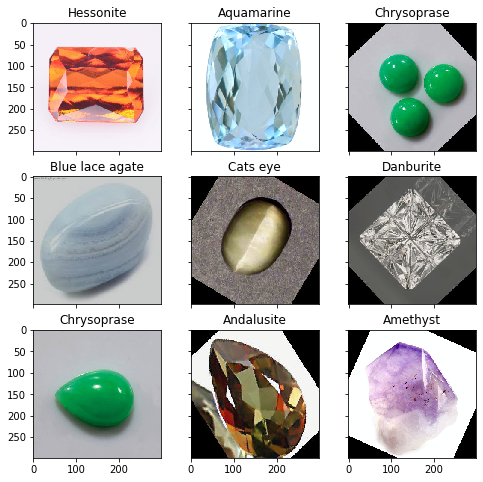

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросетей




Импортируем предобученную модель Inseption V3 и посмотрим на ее архитектуру

In [ ]:
from torchvision.models.inception import inception_v3
InceptionModel=inception_v3(pretrained=True, aux_logits=False)
print(InceptionModel)



Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth



Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, 

Список слоев Inception:

In [ ]:
print ('Слои Inception:')
for name, child in InceptionModel.named_children():
    for name2, params in child.named_parameters():
        print(name, name2)

Слои Inception:
Conv2d_1a_3x3 conv.weight
Conv2d_1a_3x3 bn.weight
Conv2d_1a_3x3 bn.bias
Conv2d_2a_3x3 conv.weight
Conv2d_2a_3x3 bn.weight
Conv2d_2a_3x3 bn.bias
Conv2d_2b_3x3 conv.weight
Conv2d_2b_3x3 bn.weight
Conv2d_2b_3x3 bn.bias
Conv2d_3b_1x1 conv.weight
Conv2d_3b_1x1 bn.weight
Conv2d_3b_1x1 bn.bias
Conv2d_4a_3x3 conv.weight
Conv2d_4a_3x3 bn.weight
Conv2d_4a_3x3 bn.bias
Mixed_5b branch1x1.conv.weight
Mixed_5b branch1x1.bn.weight
Mixed_5b branch1x1.bn.bias
Mixed_5b branch5x5_1.conv.weight
Mixed_5b branch5x5_1.bn.weight
Mixed_5b branch5x5_1.bn.bias
Mixed_5b branch5x5_2.conv.weight
Mixed_5b branch5x5_2.bn.weight
Mixed_5b branch5x5_2.bn.bias
Mixed_5b branch3x3dbl_1.conv.weight
Mixed_5b branch3x3dbl_1.bn.weight
Mixed_5b branch3x3dbl_1.bn.bias
Mixed_5b branch3x3dbl_2.conv.weight
Mixed_5b branch3x3dbl_2.bn.weight
Mixed_5b branch3x3dbl_2.bn.bias
Mixed_5b branch3x3dbl_3.conv.weight
Mixed_5b branch3x3dbl_3.bn.weight
Mixed_5b branch3x3dbl_3.bn.bias
Mixed_5b branch_pool.conv.weight
Mixed_5b bra

Импортируем предобученную модель Resnet50 и посмотрим на ее архитектуру

In [ ]:
from torchvision.models.resnet import resnet50
ResnetModel=resnet50(pretrained=True)
print(ResnetModel)



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

Список слоев Resnet:

In [ ]:
print ('Слои Resnet:')
for name, child in ResnetModel.named_children():
    for name2, params in child.named_parameters():
        print(name, name2)

Слои Resnet:
conv1 weight
bn1 weight
bn1 bias
layer1 0.conv1.weight
layer1 0.bn1.weight
layer1 0.bn1.bias
layer1 0.conv2.weight
layer1 0.bn2.weight
layer1 0.bn2.bias
layer1 0.conv3.weight
layer1 0.bn3.weight
layer1 0.bn3.bias
layer1 0.downsample.0.weight
layer1 0.downsample.1.weight
layer1 0.downsample.1.bias
layer1 1.conv1.weight
layer1 1.bn1.weight
layer1 1.bn1.bias
layer1 1.conv2.weight
layer1 1.bn2.weight
layer1 1.bn2.bias
layer1 1.conv3.weight
layer1 1.bn3.weight
layer1 1.bn3.bias
layer1 2.conv1.weight
layer1 2.bn1.weight
layer1 2.bn1.bias
layer1 2.conv2.weight
layer1 2.bn2.weight
layer1 2.bn2.bias
layer1 2.conv3.weight
layer1 2.bn3.weight
layer1 2.bn3.bias
layer2 0.conv1.weight
layer2 0.bn1.weight
layer2 0.bn1.bias
layer2 0.conv2.weight
layer2 0.bn2.weight
layer2 0.bn2.bias
layer2 0.conv3.weight
layer2 0.bn3.weight
layer2 0.bn3.bias
layer2 0.downsample.0.weight
layer2 0.downsample.1.weight
layer2 0.downsample.1.bias
layer2 1.conv1.weight
layer2 1.bn1.weight
layer2 1.bn1.bias
laye

Описываем функцию fit_epoch

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    #Обнуляем переменные
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
  
    for inputs, labels in train_loader:
        #Отправляем входные данные на GPU
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        #Обнуляем градиенты оптимайзера
        optimizer.zero_grad()

        #Проссчитываем выходные данные с помощью модели
        outputs = model(inputs)
        #Считаем loss
        loss = criterion(outputs, labels)
        #Делаем градиентный спуск
        loss.backward()
        optimizer.step()
        #Выбираем индексы максимальных значений на выходах (наше предсказание)
        preds = torch.argmax(outputs, 1)
        #Считаем текущий loss для всех входов
        running_loss += loss.item() * inputs.size(0)
        #Считаем количество правильных ответов
        running_corrects += torch.sum(preds == labels.data)
        #Прибавляем кол-во входов
        processed_data += inputs.size(0)
    #Считаем  train loss, train accuracy         
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    #Возвращаем значения train loss, train accuracy
    return train_loss, train_acc

Описываем функцию eval_epoch

In [ ]:
def eval_epoch(model, val_loader, criterion):
    #Применяем метод eval() модели
    model.eval()
    #Зануляем переменные
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        #Отправляем входные данные на GPU
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            #Проссчитываем выходные данные с помощью модели
            outputs = model(inputs)
            #Считаем loss
            loss = criterion(outputs, labels)
            #Выбираем индексы максимальных значений на выходах (наше предсказание)
            preds = torch.argmax(outputs, 1)
        #Считаем текущий loss для всех входов
        running_loss += loss.item() * inputs.size(0)
        #Считаем количество правильных ответов
        running_corrects += torch.sum(preds == labels.data)
        #Прибавляем кол-во входов
        processed_size += inputs.size(0)
    #Считаем  val loss, val accuracy 
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    #Возвращаем значения val loss, val accuracy
    return val_loss, val_acc

Тренируем сеть (функция Train). Обновляем незамороженные параметры модели, делаем оптимизацию. Ставим Scheduler для изменения learning rate оптимайзера каждые 7 эпох. Применяем кроссэнтропию. Считаем loss и accuracy. Сохраняем веса в файл.

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, mode):
    #Загружаем батчи DataLoader-ом
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    history = []
    
    #Формируем формат логов
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      params_to_update = []
      #Обновляем все "незамороженные" параметры модели
      for param in model.parameters():
        if param.requires_grad == True:
          params_to_update.append(param)
      #Задаем оптимайзер Adam
      opt = torch.optim.Adam(params_to_update, lr=0.0001)
      #Ставим Scheduler 
      scheduler=torch.optim.lr_scheduler.StepLR(opt,7,gamma=0.3)
      #Применяем кроссэнтропию
      criterion = nn.CrossEntropyLoss()

      # По каждой эпохе
      for epoch in range(epochs):
        #Применяем функцию fit_epoch
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        #Печатаем train_loss
        print("loss", train_loss)
        #Делаем "шаг" для scheduler
        scheduler.step(train_loss)
        #Применяем функцию eval_epoch
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        #Добавляем данные в history
        history.append((train_loss, train_acc, val_loss, val_acc))

        # copy the model weights. Cохраним веса в файлы в конце последней эпохи
        if epoch ==  epochs-1:
          if mode == 'i':
            torch.save(model.state_dict(), "/content/gdrive/My Drive/gemstones/output/inception_model_weights.pth").to(CPU) 
          if mode == 'r':
            torch.save(model.state_dict(), "/content/gdrive/My Drive/gemstones/output/resnet_model_weights.pth").to(CPU) 
            
       
        #Выводим логи
        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                       v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    #Возвращаем значение history       
    return history

Делаем предсказание (функция predict). Применяем softmax

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        #Для всех входных данных в даталоаделе
        for inputs in test_loader:
            #Отправляем входные данные на GPU
            inputs = inputs.to(DEVICE)
            #Применяем метод eval модели
            model.eval()
            #Просчитываем выходные данные
            outputs = model(inputs).cpu()
            #Добавляем данные в logits
            logits.append(outputs)
    #Применяем Softmax        
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Посчитаем количество классов в классификаторе

In [ ]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :87


Заморозим первые 7 слоев в Inception. Модифицируем слой fc. Установим использование GPU. Посмотрим на модель еще раз.

In [ ]:
ct=0
for name, child in InceptionModel.named_children():
    ct += 1
    if ct < 7:
        for name2, par in child.named_parameters():
          par.requires_grad = False

InceptionModel.fc = nn.Sequential(
    nn.Dropout2d(),
    nn.Linear(2048, out_features=n_classes))
    
inception_model=InceptionModel.to(DEVICE)

print(inception_model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

Заморозим первые 7 слоев в Resnet. Разморозим Bottleneck-и: layer1, layer2, layer3. Модифицируем слой fc. Установим использование GPU. Посмотрим на модель еще раз.

In [ ]:
ct=0
for name, child in ResnetModel.named_children():
    ct += 1
    if ct < 7:
        for name2, par in child.named_parameters():
          par.requires_grad = False

for param in ResnetModel.fc.parameters() or ResnetModel.layer1.parameters() or ResnetModel.layer2.parameters() or ResnetModel.layer3.parameters():
  param.requires_grad = True

ResnetModel.fc = nn.Sequential(
    nn.Dropout2d(),
    nn.Linear(ResnetModel.fc.in_features, out_features=n_classes)
    )

resnet_model=ResnetModel.to(DEVICE)

print("we will classify :{}".format(n_classes))
print(resnet_model)

we will classify :87
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

###Обучение нейросетей

Запустим обучение сети Inception

In [ ]:
#Зададим еще раз val и train части детасета
if val_dataset is None:
    val_dataset = GemstonesDataset(val_files, mode='val')
    
train_dataset = GemstonesDataset(train_files, mode='train')

In [ ]:
# Если надо, загружаем сохраненное состояние весов нейросети
#inception_model.load_state_dict(torch.load("inception_model_wights.pth"))


In [ ]:
history_inception = train(train_dataset, val_dataset, model=inception_model, epochs=5, batch_size=128, mode='i')

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.07188313001669355


epoch:  20%|██        | 1/5 [02:34<10:19, 154.81s/it]


Epoch 001 train_loss: 0.0719     val_loss 0.6644 train_acc 0.9785 val_acc 0.8441
loss 0.0574947838106381


epoch:  40%|████      | 2/5 [05:08<07:43, 154.57s/it]


Epoch 002 train_loss: 0.0575     val_loss 0.6700 train_acc 0.9835 val_acc 0.8541
loss 0.054753518663967445


epoch:  60%|██████    | 3/5 [07:42<05:08, 154.39s/it]


Epoch 003 train_loss: 0.0548     val_loss 0.6791 train_acc 0.9850 val_acc 0.8306
loss 0.050907226273791864


epoch:  80%|████████  | 4/5 [10:17<02:34, 154.36s/it]


Epoch 004 train_loss: 0.0509     val_loss 0.6106 train_acc 0.9832 val_acc 0.8616
loss 0.05988006728121893


epoch: 100%|██████████| 5/5 [12:51<00:00, 154.48s/it]


Epoch 005 train_loss: 0.0599     val_loss 0.6686 train_acc 0.9850 val_acc 0.8511


Построим кривые обучения сети Inception


In [ ]:
loss, acc, val_loss, val_acc = zip(*history_inception)

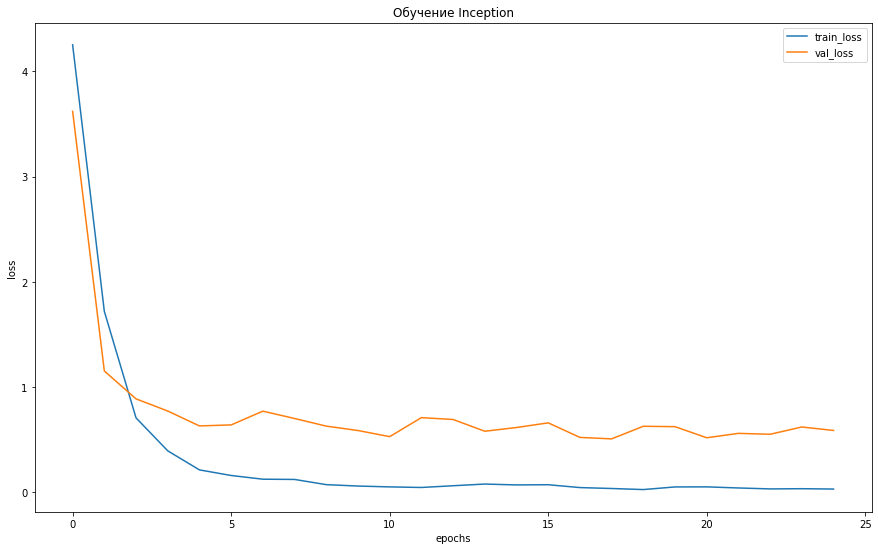

In [ ]:
plt.figure(figsize=(15, 9))
plt.title('Обучение Inception')
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Запустим обучение сети Resnet

In [ ]:
# Если надо, загружаем сохраненное состояние весов нейросети
#resnet_model.load_state_dict(torch.load("resnet_model_wights.pth"))


In [ ]:
history_resnet = train(train_dataset, val_dataset, model=resnet_model, epochs=5, batch_size=128,  mode='r')

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.10733289362956427


epoch:  20%|██        | 1/5 [02:34<10:17, 154.34s/it]


Epoch 001 train_loss: 0.1073     val_loss 0.6452 train_acc 0.9642 val_acc 0.8346
loss 0.07143675439464414


epoch:  40%|████      | 2/5 [05:08<07:42, 154.26s/it]


Epoch 002 train_loss: 0.0714     val_loss 0.6327 train_acc 0.9763 val_acc 0.8636
loss 0.06889844435536834


epoch:  60%|██████    | 3/5 [07:42<05:08, 154.12s/it]


Epoch 003 train_loss: 0.0689     val_loss 0.5388 train_acc 0.9787 val_acc 0.8751
loss 0.097095453253302


epoch:  80%|████████  | 4/5 [10:15<02:33, 153.96s/it]


Epoch 004 train_loss: 0.0971     val_loss 0.7309 train_acc 0.9717 val_acc 0.8311
loss 0.0888422869098699


epoch: 100%|██████████| 5/5 [12:48<00:00, 153.60s/it]


Epoch 005 train_loss: 0.0888     val_loss 0.6205 train_acc 0.9733 val_acc 0.8401


Построим кривые обучения сети Resnet


In [ ]:
loss, acc, val_loss, val_acc = zip(*history_resnet)

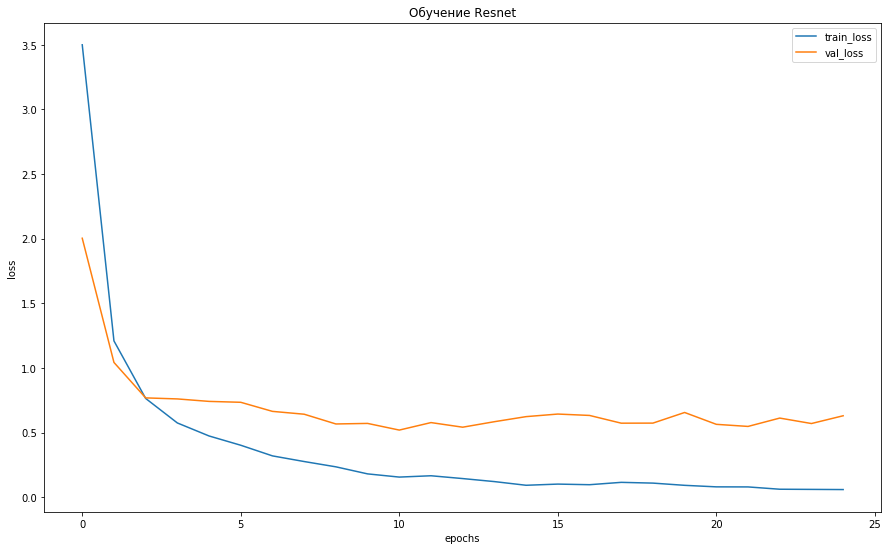

In [ ]:
plt.figure(figsize=(15, 9))
plt.title('Обучение Resnet')
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

###Строим ансамбль, делаем предсказания

Предсказание одной картинки:

Almandine
53.04732918739319
Pyrope
99.99356269836426


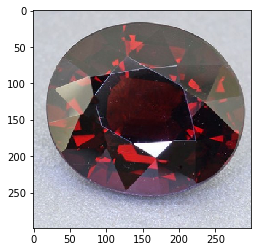

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
        #probs = np.argmax(probs_ims_resnet,-1)

    return probs
random_characters = int(np.random.uniform(0,360))
ex_img = test_dataset[random_characters]
probs_im_inception = predict_one_sample(inception_model, ex_img.unsqueeze(0))
probs_im_resnet = predict_one_sample(resnet_model, ex_img.unsqueeze(0))



predicted_proba_i = np.max(probs_im_inception)*100
predicted_proba_li = np.argmax((probs_im_inception))
predicted_proba_r = np.max(probs_im_resnet)*100
predicted_proba_lr = np.argmax((probs_im_resnet))
pthi=label_encoder.classes_[predicted_proba_li]
pthr=label_encoder.classes_[predicted_proba_lr]

print(pthi)
print(predicted_proba_i)
print(pthr)
print(predicted_proba_r)


imshow(ex_img.cpu())



Как должен выглядеть предсказанный камень:

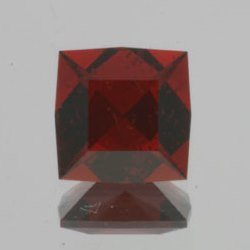

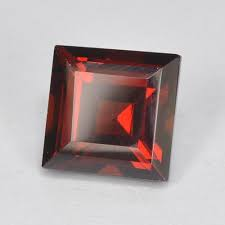

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
im1= cv2.imread(os.path.join('/content/gdrive/My Drive/gemstones/train',pthi, str.lower(pthi)+'_1.jpg'))
print(pthi)
cv2_imshow(im1)
im2= cv2.imread(os.path.join('/content/gdrive/My Drive/gemstones/train',pthr, str.lower(pthr)+'_1.jpg'))
print(pthr)
cv2_imshow(im2)

Посмотрим на предсказания Resnet, Inception и ансамбля на валидационной выборке.

Ансамбль строим по принципу голосования. Но считаем, что лучшие предсказания дает сеть Inception. Поэтому, если обе сети дают одинаковое количество голосов, выбираем предсказание Inception. 

Здесь уже видно, что ансамбль дает лучший результат, чем одна сеть.

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]


probs_ims_inception = predict(inception_model, imgs)
probs_ims_resnet = predict(resnet_model, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred_resnet = np.argmax(probs_ims_resnet,-1)
y_pred_inception = np.argmax(probs_ims_inception,-1)
print ('Предсказание Resnet:    ', y_pred_resnet)
print('Предсказание Inception: ',y_pred_inception)

actual_labels = [val_dataset[id][1] for id in idxs]
y_pred=[]
for i in range(len(actual_labels)):
  if y_pred_resnet[i] == y_pred_inception[i]:
    y_pred.append(y_pred_inception[i])
  elif probs_ims_resnet[i,y_pred_resnet[i]]>probs_ims_inception[i,y_pred_inception[i]]:
    y_pred.append(y_pred_resnet[i])
  else:
    y_pred.append(y_pred_inception[i]) 
print('Предсказания ансамбля:  ',np.array(y_pred))
print('Правильный ответ:       ',np.array(actual_labels))

Предсказание Resnet:     [10 11  0  7 34 24 15 22 45 53  7 40 19 23 40  7 32 31 22 68]
Предсказание Inception:  [10 11  0  7 34 12 15 22 22 58  7 40 41 23 40  7 32 31 22  4]
Предсказания ансамбля:   [10, 11, 0, 7, 34, 24, 15, 22, 22, 58, 7, 40, 41, 23, 40, 7, 32, 31, 22, 4]
Правильный ответ:        [10, 11, 0, 7, 34, 12, 15, 22, 22, 21, 6, 40, 41, 23, 40, 7, 32, 31, 22, 4]


Вычислим F1-score Resnet, Inception и ансамбля на валидационной выборке. 

In [ ]:

    
from sklearn.metrics import f1_score
sc_resnet=f1_score(actual_labels, y_pred_resnet, average='macro')
print ('Предсказание Resnet: F1_score=', sc_resnet)
sc_inception=f1_score(actual_labels, y_pred_inception, average='macro')
print ('Предсказание Inception: F1_score=', sc_inception)
sc=f1_score(actual_labels, y_pred, average='macro')
print ('Предсказание ансамбля: F1_score=',sc)


Предсказание Resnet: F1_score= 0.5047619047619047
Предсказание Inception: F1_score= 0.8117647058823529
Предсказание ансамбля: F1_score= 0.7111111111111111


Сделаем визуализацию, чтобы наглядней увидеть результаты обучения

Предсказания Resnet


findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans.


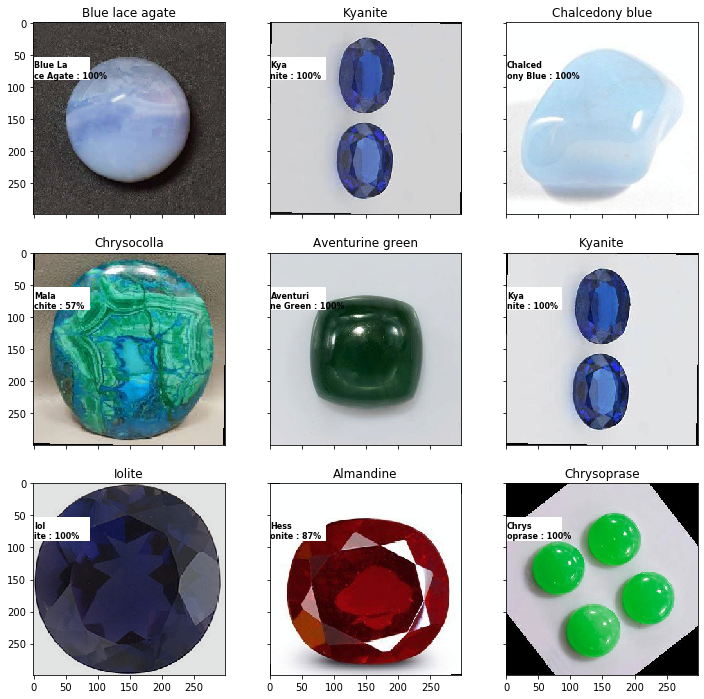

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
print("Предсказания Resnet")
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Предсказания Inception


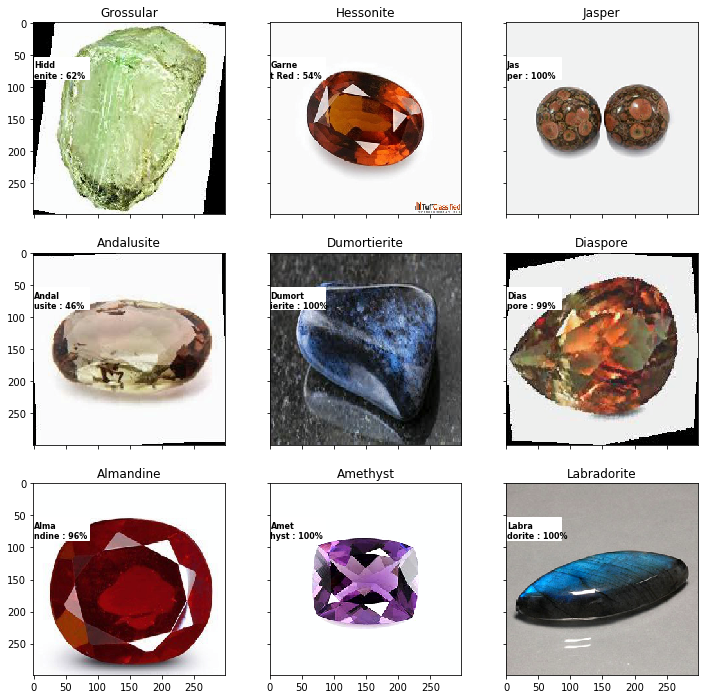

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
print("Предсказания Inception")
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(inception_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Предсказания ансамбля


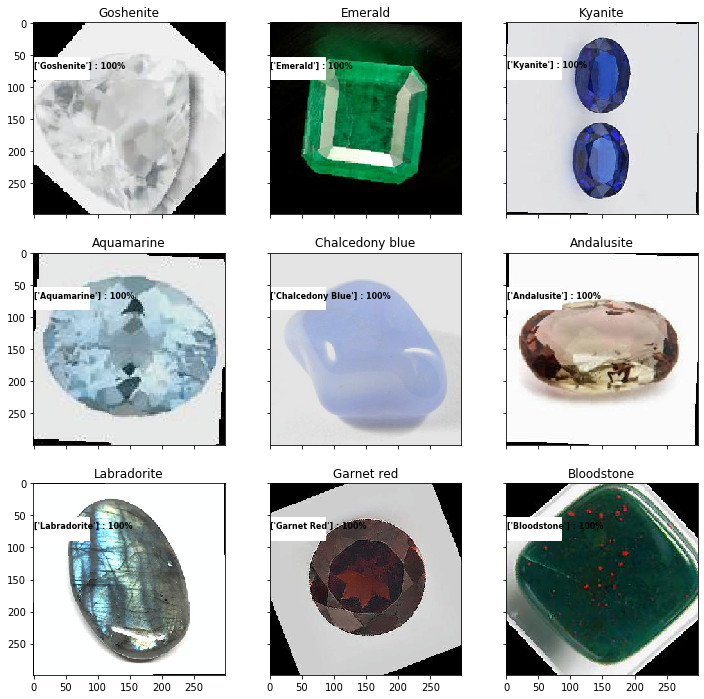

In [ ]:

import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
print("Предсказания ансамбля")
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred_inception = predict_one_sample(inception_model, im_val.unsqueeze(0))
    prob_pred_resnet = predict_one_sample(resnet_model, im_val.unsqueeze(0))

    y_pred_resnet = np.argmax(prob_pred_resnet,-1)
    y_pred_inception= np.argmax(prob_pred_inception,-1)
    
    y_pred=[]
    for i in range(1):

      if y_pred_resnet[i] == y_pred_inception[i]:
        y_pred.append(y_pred_resnet[i])
        predicted_proba = np.max(prob_pred_resnet)*100
      elif prob_pred_resnet[i,y_pred_resnet[i]]>prob_pred_inception[i,y_pred_inception[i]]:
        y_pred.append(y_pred_resnet[i])
        predicted_proba = np.max(prob_pred_resnet)*100
      else:
        y_pred.append(y_pred_inception[i]) 
        predicted_proba = np.max(prob_pred_inception)*100
    


    predicted_proba = np.max(prob_pred)*100
    
    
    predicted_label = label_encoder.classes_[y_pred]
   # predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')


###Определим точность для каждого класса и построим Confusion matrix

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
    
   
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    
def show_confusion_matrix_fucn(model):
    """Построить и посчитать точность классов по confusion matrix"""
    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()

    # Пройдём по всему validation датасету и запишем ответы сети
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            predictions = model(inputs.to(DEVICE))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)

            # Аналог append для list
            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()

    # Функция из sklearn, создаёт confusion матрицу
    cm = confusion_matrix(y_test_all, predictions_all, np.arange(n_classes))
    # Выведем её
    plot_confusion_matrix(cm, feature_names, normalize=True)
    
    return y_test_all, predictions_all
  
def accurancy_for_each_class(y_test_all, predictions_all):
    class_correct = [0 for i in range(n_classes)]
    class_total = [0 for i in range(n_classes)]
    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(n_classes):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))
    

In [ ]:
BATCH_SIZE = 128
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

Для сети Inception:
Normalized confusion matrix
[15, 33, 31, 18, 29, 22, 18, 22, 30, 23, 25, 24, 14, 23, 20, 23, 23, 20, 22, 24, 19, 21, 19, 25, 30, 22, 20, 28, 17, 21, 18, 20, 34, 18, 30, 17, 35, 15, 15, 20, 28, 18, 22, 23, 24, 24, 22, 26, 23, 21, 25, 22, 22, 19, 24, 21, 21, 22, 21, 25, 22, 22, 27, 20, 26, 22, 30, 28, 20, 23, 23, 22, 26, 22, 21, 24, 25, 18, 21, 22, 17, 18, 31, 22, 22, 42, 29]
87
Accuracy of Alexandrite : 100 %
Accuracy of Almandine : 60 %
Accuracy of Amazonite : 74 %
Accuracy of Amber : 100 %
Accuracy of Amethyst : 72 %
Accuracy of Ametrine : 100 %
Accuracy of Andalusite : 94 %
Accuracy of Andradite : 72 %
Accuracy of Aquamarine : 70 %
Accuracy of Aventurine : 95 %
Accuracy of Aventurine Green : 88 %
Accuracy of Benitoite : 87 %
Accuracy of Beryl Golden : 92 %
Accuracy of Beryl Red : 86 %
Accuracy of Bloodstone : 100 %
Accuracy of Blue Lace Agate : 100 %
Accuracy of Carnelian : 91 %
Accuracy of Cats Eye : 100 %
Accuracy of Chalcedony : 86 %
Accuracy of Chalcedony Blue

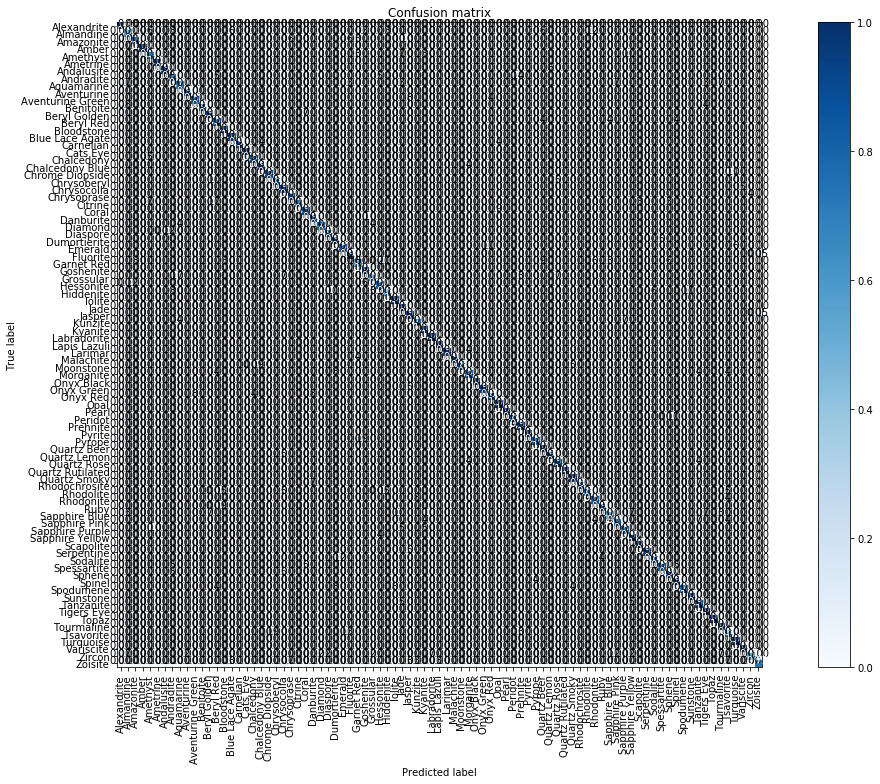

In [ ]:
print ('Для сети Inception:')
y_test_all, predictions_all = show_confusion_matrix_fucn(inception_model)
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all)

Для сети Resnet:
Normalized confusion matrix
[24, 13, 26, 14, 12, 23, 17, 31, 22, 24, 24, 24, 18, 20, 25, 24, 23, 23, 9, 23, 19, 13, 29, 27, 31, 18, 18, 21, 34, 22, 21, 22, 24, 34, 23, 28, 24, 28, 18, 22, 28, 23, 21, 23, 24, 25, 22, 19, 24, 22, 23, 22, 23, 25, 23, 15, 34, 24, 24, 20, 23, 17, 36, 30, 23, 24, 22, 22, 25, 22, 21, 19, 23, 29, 32, 23, 15, 20, 22, 27, 20, 26, 27, 21, 20, 32, 21]
87
Accuracy of Alexandrite : 87 %
Accuracy of Almandine : 100 %
Accuracy of Amazonite : 84 %
Accuracy of Amber : 92 %
Accuracy of Amethyst : 100 %
Accuracy of Ametrine : 100 %
Accuracy of Andalusite : 100 %
Accuracy of Andradite : 58 %
Accuracy of Aquamarine : 90 %
Accuracy of Aventurine : 87 %
Accuracy of Aventurine Green : 83 %
Accuracy of Benitoite : 83 %
Accuracy of Beryl Golden : 72 %
Accuracy of Beryl Red : 95 %
Accuracy of Bloodstone : 84 %
Accuracy of Blue Lace Agate : 95 %
Accuracy of Carnelian : 78 %
Accuracy of Cats Eye : 91 %
Accuracy of Chalcedony : 100 %
Accuracy of Chalcedony Blue : 95

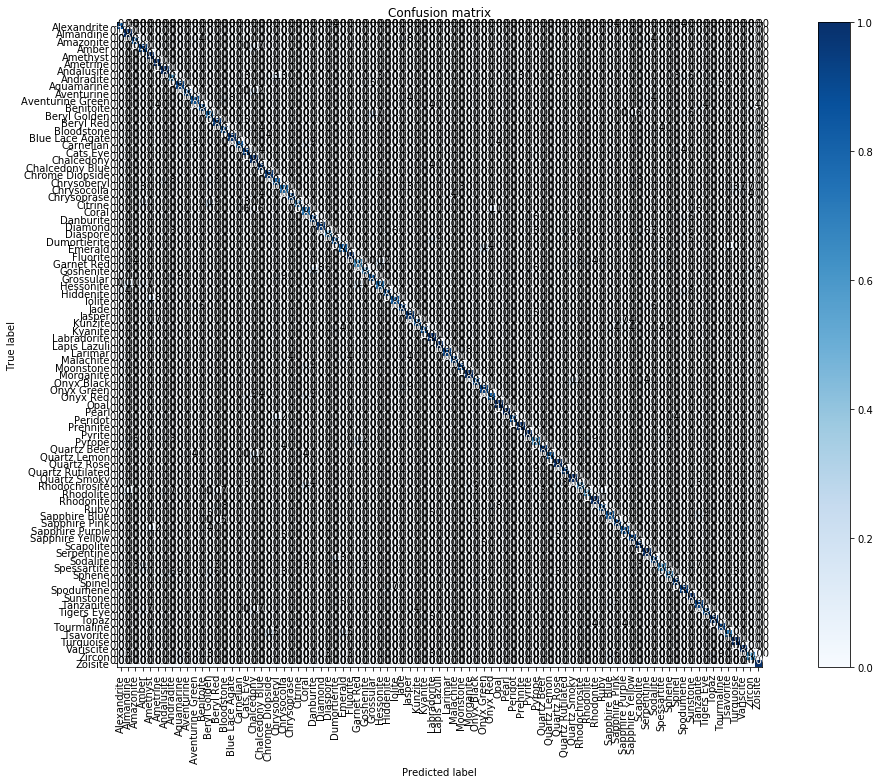

In [ ]:
print ('Для сети Resnet:')
y_test_all, predictions_all = show_confusion_matrix_fucn(resnet_model)
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all)